In [62]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


In [63]:
def mase(y_true, y_pred, y_train):
    """
    Calculate MASE (Mean Absolute Scaled Error).
    y_true: Actual values
    y_pred: Predicted values
    y_train: Training data (used to calculate naive forecast errors)
    """
    # Calculate MAE of the forecast
    mae_forecast = np.mean(np.abs(y_true - y_pred))
    
    # Calculate MAE of the naive forecast (shifted by one time step)
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    if (mae_naive == 0):
        print("Danger")
    
    # Calculate MASE
    mase_value = mae_forecast / mae_naive
    return mase_value

In [64]:
df = pd.read_csv("parkingLot_missing_values.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
camera_1 = df[df["camera_id"] == 1]
camera_2 = df[df["camera_id"] == 2]


start_date='2024-09-12'
end_date = '2024-11-14'
timestamps = pd.date_range(start=start_date,end=end_date,freq='20 MIN')
timestamps = pd.Series(timestamps[timestamps.indexer_between_time('05:00:00','00:00:00')][1:])
timestamps_df = pd.DataFrame()
timestamps_df["timestamp"] = timestamps



camera_1_count = camera_1.groupby("timestamp").size()
camera_2_count = camera_2.groupby("timestamp").size()

ALL_time = timestamps_df.groupby("timestamp").size()*0

num_vehicle_enter = ALL_time.add(camera_1_count, fill_value=0).astype(int).reset_index(name="count")
num_vehicle_leave = ALL_time.add(camera_2_count, fill_value=0).astype(int).reset_index(name="count")

camera_1_count = camera_1.groupby("timestamp").size().reset_index(name="count")
camera_2_count = camera_2.groupby("timestamp").size().reset_index(name="count")

vehicles_entered = num_vehicle_enter["count"].values.reshape((-1,58)).sum(axis=1)
vehicles_leave = num_vehicle_leave["count"].values.reshape((-1,58)).sum(axis=1)


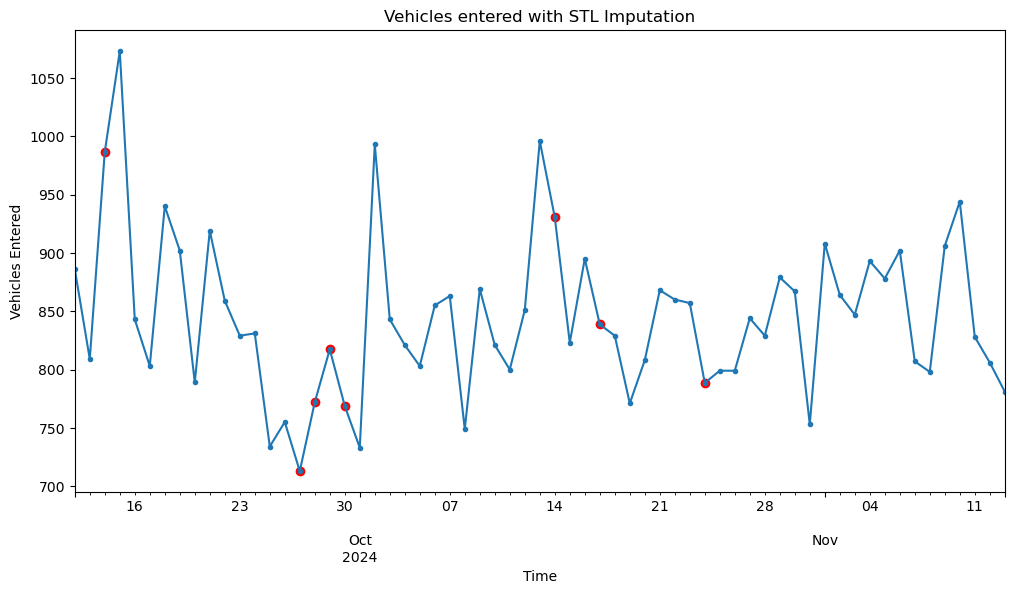

In [65]:
from statsmodels.tsa.seasonal import STL

df_entry_stl = pd.DataFrame()
df_entry_stl.index = pd.date_range(start=start_date, end="2024-11-13")
df_entry_stl["count"] = vehicles_entered
df_entry_stl['count'].replace(0, np.nan, inplace=True)
df_entry_stl_copy = df_entry_stl.copy()


imputed_indices = df_entry_stl[df_entry_stl["count"].isnull()].index

# Apply STL decompostion
stl = STL(df_entry_stl_copy["count"].interpolate())
res = stl.fit()

# Extracting the seasonal and trend components
seasonal_component = res.seasonal
df_deseasonalised = df_entry_stl_copy['count'] - seasonal_component

df_deseasonalised_imputed = df_deseasonalised.interpolate(method="time")

# Adding the seasonal component back to create the final imputed series
df_imputed = df_deseasonalised_imputed + seasonal_component

df_entry_stl_copy.loc[imputed_indices, 'count'] = df_imputed[imputed_indices]


plt.figure(figsize=[12, 6])
df_entry_stl_copy['count'].plot(style='.-',  label='Vehicle Entered')
plt.scatter(imputed_indices, df_entry_stl_copy.loc[imputed_indices, 'count'], color='red')

plt.title("Vehicles entered with STL Imputation")
plt.ylabel("Vehicles Entered")
plt.xlabel("Time")
plt.show()


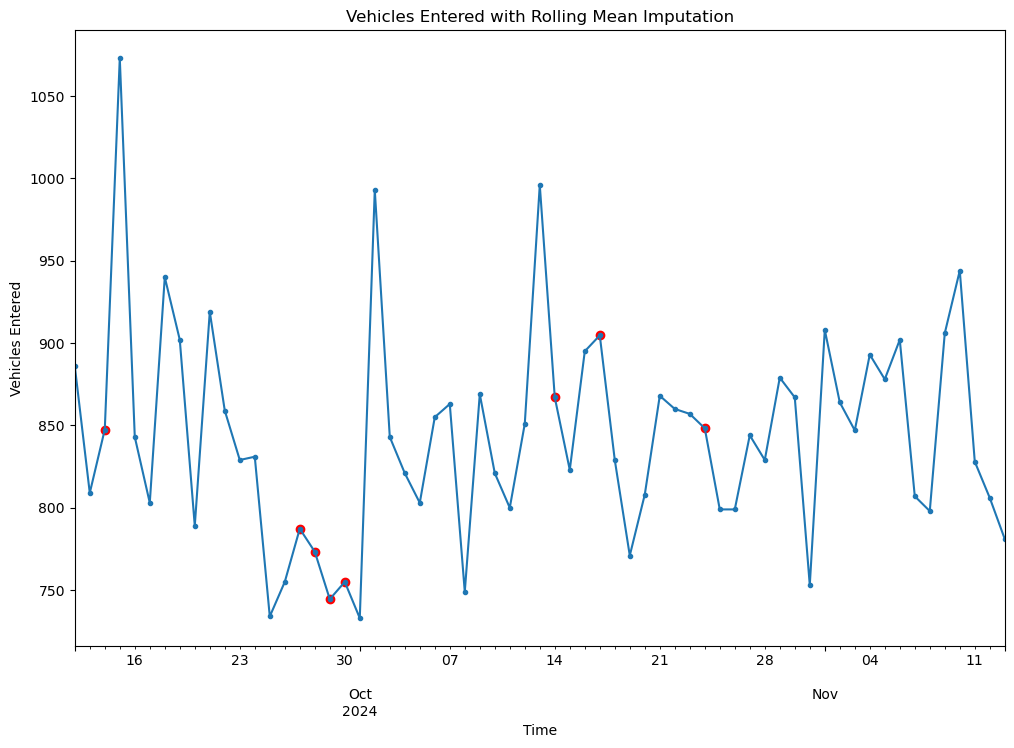

In [66]:
df_entry_rolling = pd.DataFrame()
df_entry_rolling.index = pd.date_range(start=start_date, end="2024-11-13")
df_entry_rolling["count"] = vehicles_entered
df_entry_rolling['count'].replace(0, np.nan, inplace=True)

df_entry_rolling_copy = df_entry_rolling.copy()


imputed_indices = df_entry_rolling_copy[df_entry_rolling_copy['count'].isnull()].index

df_entry_rolling_copy['count'] = df_entry_rolling_copy['count'].fillna(df_entry_rolling_copy['count'].rolling(window=4, min_periods=1).mean().shift(1))


df_entry_rolling_copy['count'].plot(style='.-', figsize=(12,8), title='Vehicles Entered with Rolling Mean Imputation')


plt.scatter(imputed_indices, df_entry_rolling_copy.loc[imputed_indices, 'count'], color='red')

plt.xlabel('Time')
plt.ylabel('Vehicles Entered')

plt.show()

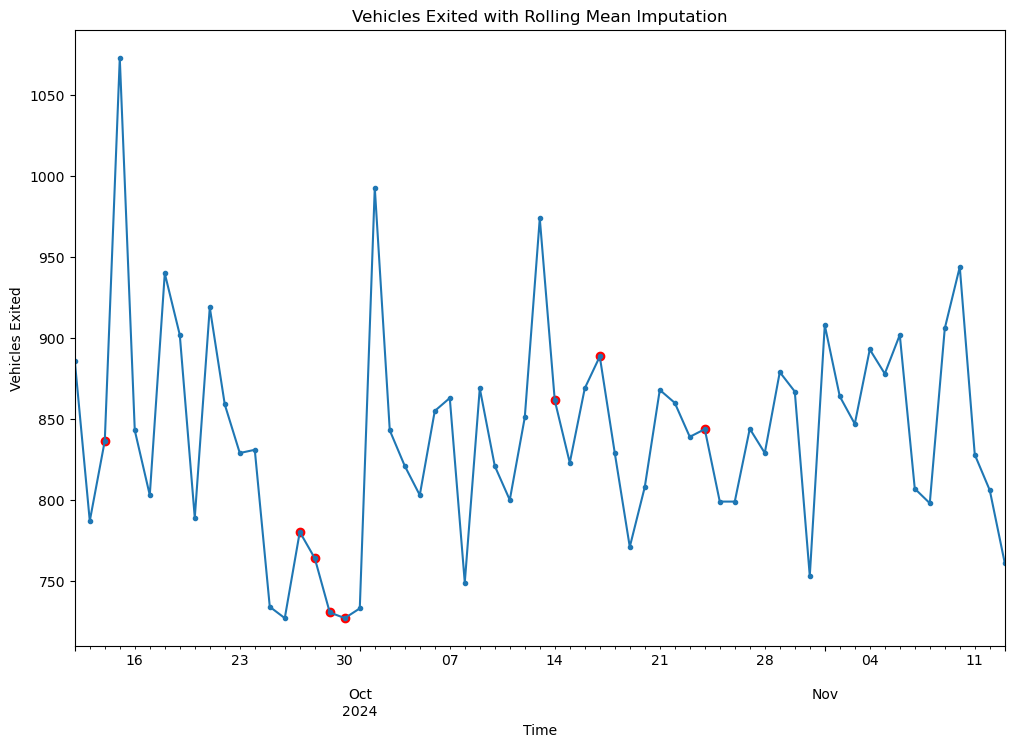

In [67]:
df_exit_rolling = pd.DataFrame()
df_exit_rolling.index = pd.date_range(start=start_date, end="2024-11-13")
df_exit_rolling["count"] = vehicles_leave
df_exit_rolling["count"] = df_exit_rolling['count'].where(df_exit_rolling["count"] >= 50, np.nan)


df_exit_rolling_copy = df_exit_rolling.copy()

imputed_indices = df_exit_rolling_copy[df_exit_rolling_copy['count'].isnull()].index

df_exit_rolling_copy['count'] = df_exit_rolling_copy['count'].fillna(df_exit_rolling_copy['count'].rolling(window=4, min_periods=1).mean().shift(1))


df_exit_rolling_copy['count'].plot(style='.-', figsize=(12,8), title='Vehicles Exited with Rolling Mean Imputation')


plt.scatter(imputed_indices, df_exit_rolling_copy.loc[imputed_indices, 'count'], color='red')


plt.xlabel('Time')
plt.ylabel('Vehicles Exited')

plt.show()

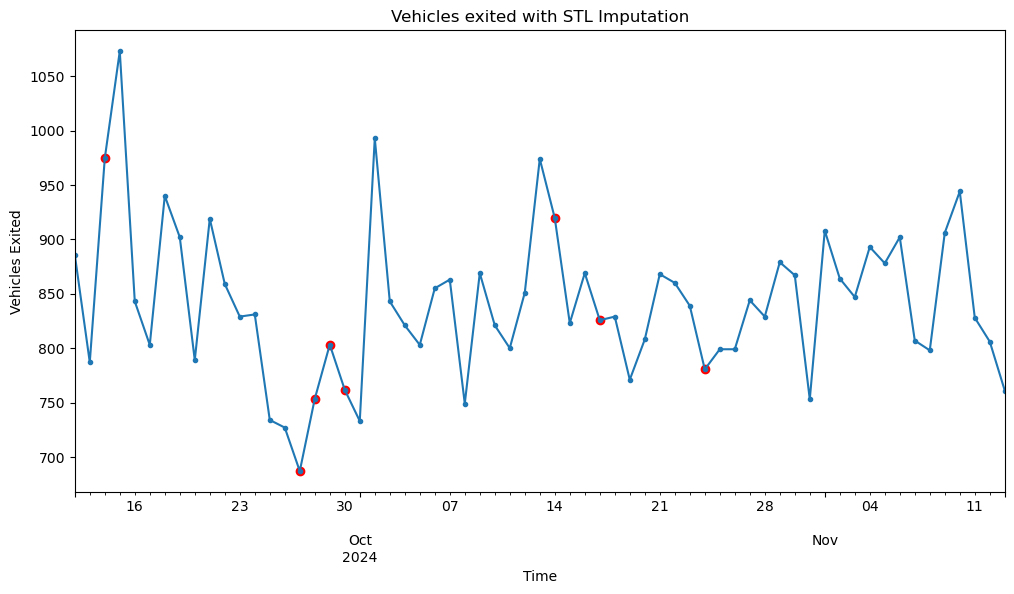

In [68]:
from statsmodels.tsa.seasonal import STL

df_exit_stl = pd.DataFrame()
df_exit_stl.index = pd.date_range(start=start_date, end="2024-11-13")
df_exit_stl["count"] = vehicles_leave
df_exit_stl["count"] = df_exit_stl['count'].where(df_exit_stl["count"] >= 50, np.nan)
df_exit_stl_copy = df_exit_stl.copy()


imputed_indices = df_exit_stl_copy[df_exit_stl_copy["count"].isnull()].index

stl = STL(df_exit_stl_copy["count"].interpolate())
res = stl.fit()


seasonal_component = res.seasonal

df_deseasonalised = df_exit_stl_copy['count'] - seasonal_component

df_deseasonalised_imputed = df_deseasonalised.interpolate(method="time")

df_imputed = df_deseasonalised_imputed + seasonal_component

df_exit_stl_copy.loc[imputed_indices, 'count'] = df_imputed[imputed_indices]


plt.figure(figsize=[12, 6])
df_exit_stl_copy['count'].plot(style='.-',  label='Vehicle Entered')
plt.scatter(imputed_indices, df_exit_stl_copy.loc[imputed_indices, 'count'], color='red')

plt.title("Vehicles exited with STL Imputation")
plt.ylabel("Vehicles Exited")
plt.xlabel("Time")
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.38806D+00    |proj g|=  1.47983D+00

At iterate    5    f=  5.71466D+00    |proj g|=  2.58965D-02

At iterate   10    f=  5.70516D+00    |proj g|=  1.05876D-03

At iterate   15    f=  5.70313D+00    |proj g|=  1.13831D-02

At iterate   20    f=  5.70098D+00    |proj g|=  5.86876D-04

At iterate   25    f=  5.70004D+00    |proj g|=  5.60146D-03

At iterate   30    f=  5.69916D+00    |proj g|=  9.49575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


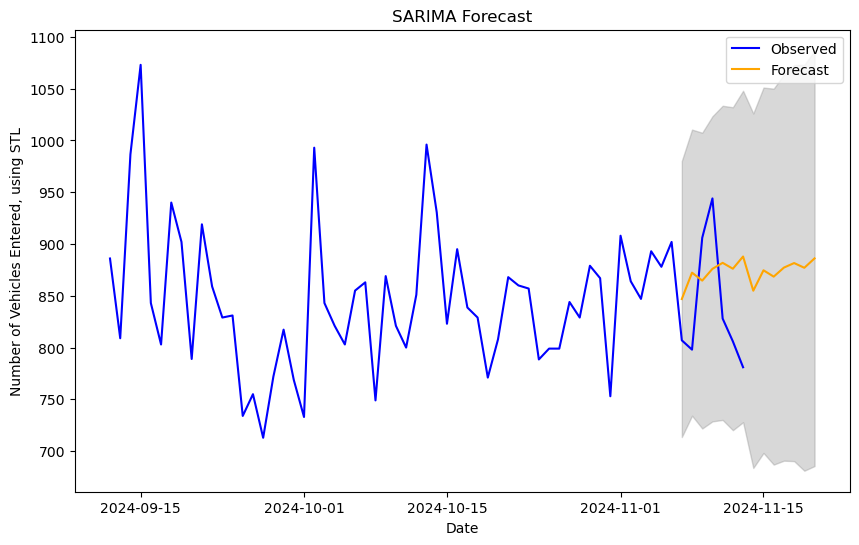

In [69]:
model = SARIMAX(df_entry_stl_copy['count'][:-7], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
results = model.fit()


forecast = results.get_forecast(steps=14)
forecast_index = pd.date_range(start=df_entry_stl_copy.index[-7], periods=14, freq='D')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

MASE_sarima_stl_entry = mase(df_entry_stl_copy["count"].values[-7:], forecast_values[-14:-7], df_entry_stl_copy["count"].values[:-7])
MSE_sarima_stl_entry = mean_squared_error(df_entry_stl_copy["count"].values[-7:], forecast_values[-14:-7])



print("ARIMA Forecast for next 7 days:\n", forecast_values[-7:], sep="")
print("\nMean absolute scaled error is: ", MASE_sarima_stl_entry)

MAPE_sarima_stl_entry = mean_absolute_percentage_error(df_entry_stl_copy["count"].values[-7:],forecast_values[-14:-7]) * 100
print("Mean absolute percentage error is: ", MAPE_sarima_stl_entry)


plt.figure(figsize=(10, 6))
plt.plot(df_entry_stl_copy.index, df_entry_stl_copy['count'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entered, using STL')
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25277D+03    |proj g|=  5.27080D+03

At iterate    5    f=  9.03348D+00    |proj g|=  7.23334D+00

At iterate   10    f=  6.40720D+00    |proj g|=  3.82501D-01

At iterate   15    f=  5.77493D+00    |proj g|=  4.89078D-02

At iterate   20    f=  5.69196D+00    |proj g|=  2.90532D-02

At iterate   25    f=  5.68176D+00    |proj g|=  9.95665D-04

At iterate   30    f=  5.68072D+00    |proj g|=  1.23283D-03

At iterate   35    f=  5.68032D+00    |proj g|=  8.77141D-05

At iterate   40    f=  5.67989D+00    |proj g|=  5.57124D-04

At iterate   45    f=  5.67946D+00    |proj g|=  3.05469D-04

At iterate   50    f=  5.67932D+00    |proj g|=  1.10615D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


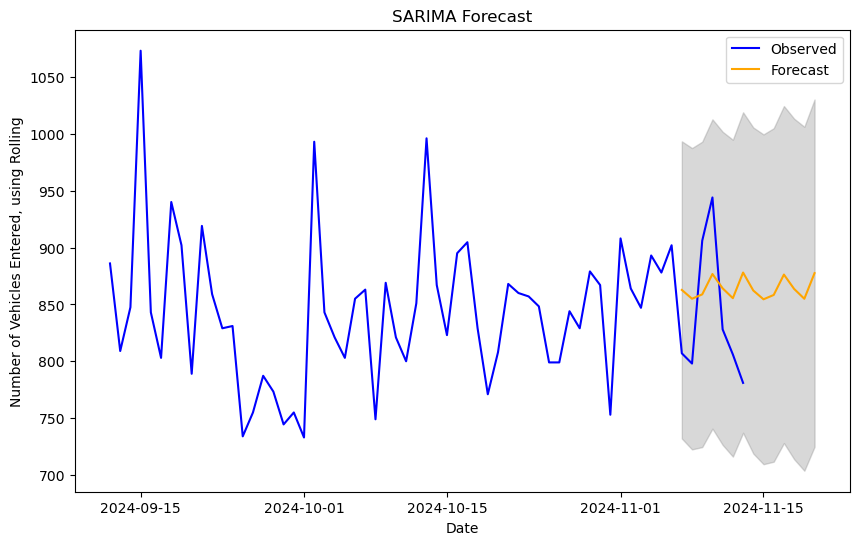

In [70]:
model = SARIMAX(df_entry_rolling_copy['count'][:-7], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
results = model.fit()


forecast = results.get_forecast(steps=14)
forecast_index = pd.date_range(start=df_entry_rolling_copy.index[-7], periods=14, freq='D')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

MASE_sarima_rolling_entry = mase(df_entry_rolling_copy["count"].values[-7:], forecast_values[-14:-7], df_entry_rolling_copy["count"].values[:-7])
MSE_sarima_rolling_entry = mean_squared_error(df_entry_rolling_copy["count"].values[-7:], forecast_values[-14:-7])


print("-------- SARIMA Forecast for next 7 days ---------\n\n\n\n", forecast_values[-7:], sep="")
print("\nMean absolute scaled error is: ", MASE_sarima_rolling_entry)

MAPE_sarima_rolling_entry = mean_absolute_percentage_error(df_entry_rolling_copy["count"].values[-7:],forecast_values[-14:-7]) * 100
print("Mean absolute percentage error is: ", MAPE_sarima_rolling_entry)


plt.figure(figsize=(10, 6))
plt.plot(df_entry_rolling_copy.index, df_entry_rolling_copy['count'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles Entered, using Rolling')
plt.legend()
plt.show()

In [71]:
num_vehicle_enter["timestamp"] = pd.to_datetime(num_vehicle_enter["timestamp"])
time_hr = num_vehicle_enter["timestamp"].dt.time
min_arr = pd.to_timedelta(time_hr.astype(str)).dt.total_seconds() // 60
min_arr = min_arr.values[0:58]
min_arr[-1] = 1440


total_time_entered = (num_vehicle_enter["count"].values.reshape(-1,58)*min_arr).sum(axis=1)
total_time_left = (num_vehicle_leave["count"].values.reshape(-1,58)*min_arr).sum(axis=1)

total_time_left = [x if x > 100000 else 0 for x in total_time_left]
total_time_entered = [x if x > 100000 else 0 for x in total_time_entered]

avg = (pd.Series(total_time_left) - pd.Series(total_time_entered)) 

avg = avg / pd.Series(df_entry_stl_copy["count"].values)



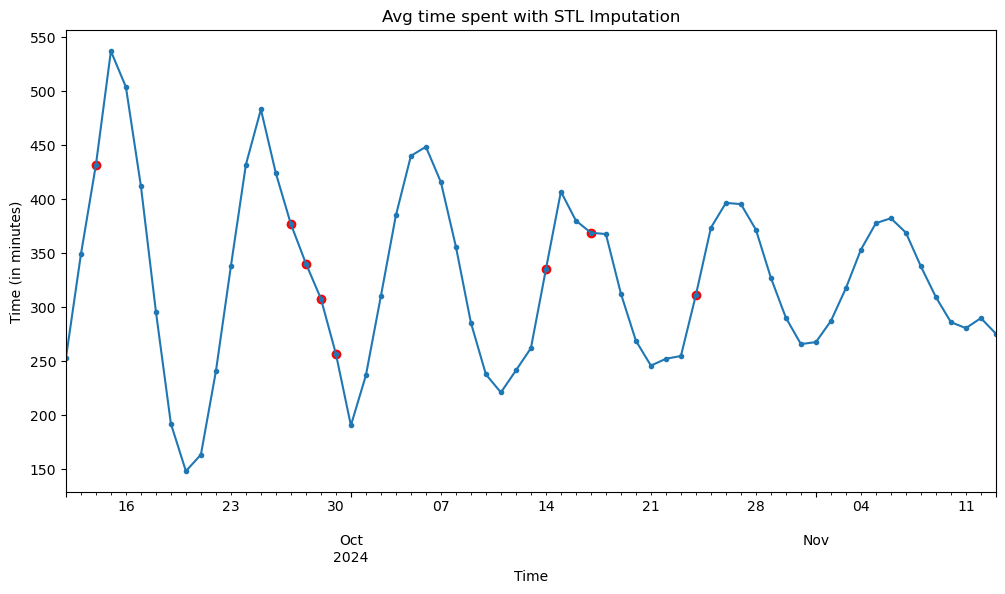

In [72]:
from statsmodels.tsa.seasonal import STL


df_avg_stl = pd.DataFrame()
df_avg_stl.index = pd.date_range(start=start_date, end="2024-11-13")
df_avg_stl["count"] = avg.values
df_avg_stl["count"] = df_avg_stl['count'].where(df_avg_stl["count"] >= 50, np.nan)
df_avg_stl_copy = df_avg_stl.copy()



imputed_indices = df_avg_stl_copy[df_avg_stl_copy["count"].isnull()].index

stl = STL(df_avg_stl_copy["count"].interpolate())
res = stl.fit()


seasonal_component = res.seasonal

df_deseasonalised = df_avg_stl_copy['count'] - seasonal_component


df_deseasonalised_imputed = df_deseasonalised.interpolate(method="time")


df_imputed = df_deseasonalised_imputed + seasonal_component

df_avg_stl_copy.loc[imputed_indices, 'count'] = df_imputed[imputed_indices]


plt.figure(figsize=[12, 6])
df_avg_stl_copy['count'].plot(style='.-',  label='Vehicle Entered')
plt.scatter(imputed_indices, df_avg_stl_copy.loc[imputed_indices, 'count'], color='red')

plt.title("Avg time spent with STL Imputation")
plt.ylabel("Time (in minutes)")
plt.xlabel("Time")
plt.show()


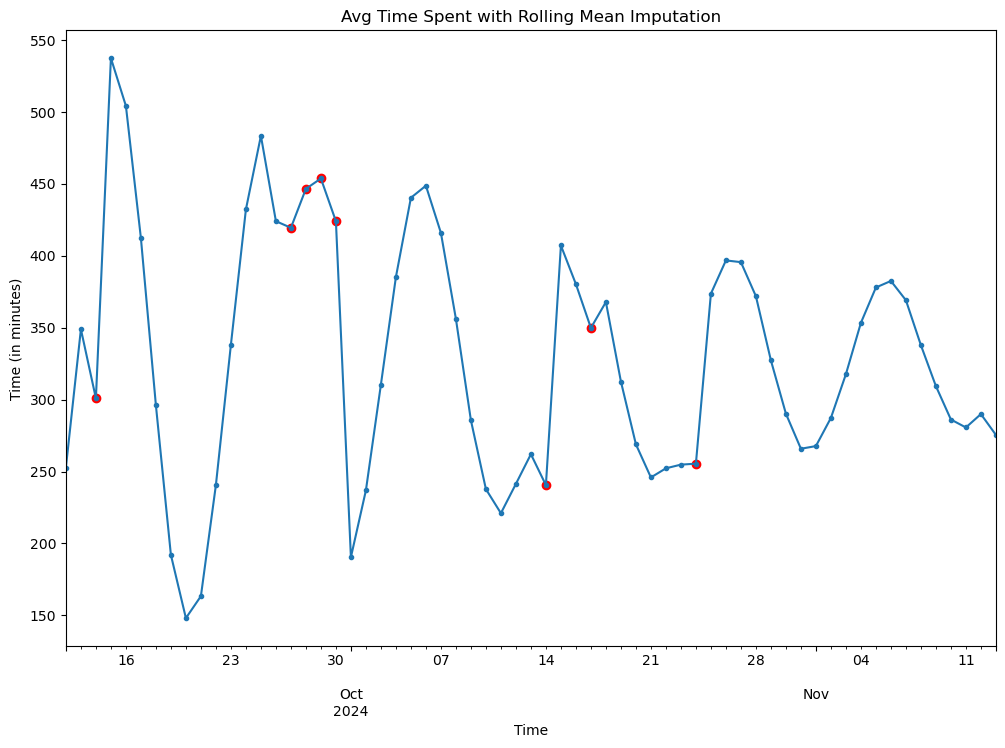

In [73]:


df_avg_rolling = pd.DataFrame()
df_avg_rolling.index = pd.date_range(start=start_date, end="2024-11-13")
df_avg_rolling["count"] = avg.values
df_avg_rolling["count"] = df_avg_rolling['count'].where(df_avg_rolling["count"] >= 50, np.nan)


df_avg_rolling_copy = df_avg_rolling.copy()

imputed_indices = df_avg_rolling_copy[df_avg_rolling_copy['count'].isnull()].index

df_avg_rolling_copy['count'] = df_avg_rolling_copy['count'].fillna(df_avg_rolling_copy['count'].rolling(window=4, min_periods=1).mean().shift(1))


df_avg_rolling_copy['count'].plot(style='.-', figsize=(12,8), title='Avg Time Spent with Rolling Mean Imputation')


plt.scatter(imputed_indices, df_avg_rolling_copy.loc[imputed_indices, 'count'], color='red')

plt.xlabel('Time')
plt.ylabel('Time (in minutes)')

plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08405D+00    |proj g|=  2.11196D+00

At iterate    5    f=  5.13451D+00    |proj g|=  1.22401D-02

At iterate   10    f=  5.10439D+00    |proj g|=  8.59779D-03

At iterate   15    f=  5.10020D+00    |proj g|=  4.53308D-03

At iterate   20    f=  5.08702D+00    |proj g|=  9.96256D-03

At iterate   25    f=  5.06835D+00    |proj g|=  2.06465D-03

At iterate   30    f=  5.06296D+00    |proj g|=  1.29506D-02

At iterate   35    f=  5.05776D+00    |proj g|=  1.45283D-03

At iterate   40    f=  5.05760D+00    |proj g|=  3.55392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


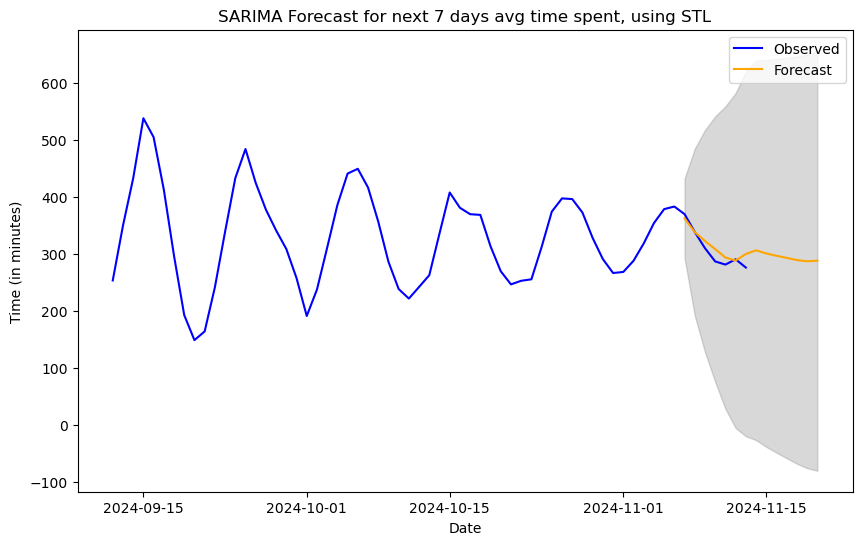

In [74]:
model = SARIMAX(df_avg_stl_copy['count'][:-7], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
results = model.fit()


forecast = results.get_forecast(steps=14)
forecast_index = pd.date_range(start=df_avg_stl_copy.index[-7], periods=14, freq='D')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

MASE_sarima_stl_avg = mase(df_avg_stl_copy["count"].values[-7:], forecast_values[-14:-7], df_avg_stl_copy["count"].values[:-7])
MSE_sarima_stl_avg = mean_squared_error(df_avg_stl_copy["count"].values[-7:], forecast_values[-14:-7])


print("SARIMA Forecast for next 7 days:\n", forecast_values[-7:], sep="")
print("\nMean absolute scaled error is: ", MASE_sarima_stl_avg)

MAPE_sarima_stl_avg = mean_absolute_percentage_error(df_avg_stl_copy["count"].values[-7:],forecast_values[-14:-7]) * 100
print("Mean absolute percentage error is: ", MAPE_sarima_stl_avg)



plt.figure(figsize=(10, 6))
plt.plot(df_avg_stl_copy.index, df_avg_stl_copy['count'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.3)
plt.title('SARIMA Forecast for next 7 days avg time spent, using STL')
plt.xlabel('Date')
plt.ylabel('Time (in minutes)')
plt.legend()
plt.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84703D+00    |proj g|=  2.89049D-01

At iterate    5    f=  5.71060D+00    |proj g|=  9.42457D-03

At iterate   10    f=  5.69829D+00    |proj g|=  3.05228D-02

At iterate   15    f=  5.68965D+00    |proj g|=  1.13979D-03

At iterate   20    f=  5.68634D+00    |proj g|=  9.25774D-04

At iterate   25    f=  5.68628D+00    |proj g|=  3.73888D-03
ARIMA Forecast for next 7 days:
2024-11-14    301.380941
2024-11-15    300.427594
2024-11-16    293.931307
2024-11-17    296.716144
2024-11-18    288.189108
2024-11-19    276.592178
2024-11-20    265.106972
Freq: D, Name: predicted_mean, dtype: float64

Mean absolute scaled error is:  0.8065738111066624
Mean absolute percentage error is:  13.963405129358458

At iterate   30    f=  5.68619D+00    |proj g|=  1.20593D-04

At iterate   35    f=  5.68616D+00    

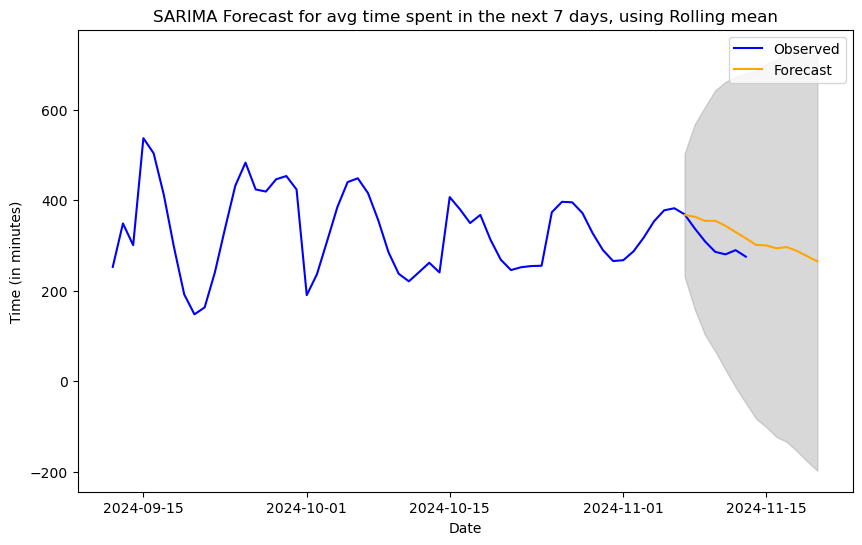

In [75]:
model = SARIMAX(df_avg_rolling_copy['count'][:-7], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
results = model.fit()




forecast = results.get_forecast(steps=14)
forecast_index = pd.date_range(start=df_avg_rolling_copy.index[-7], periods=14, freq='D')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

MASE_sarima_rolling_avg = mase(df_avg_rolling_copy["count"].values[-7:], forecast_values[-14:-7], df_avg_rolling_copy["count"].values[:-7])
MSE_sarima_rolling_avg = mean_squared_error(df_avg_rolling_copy["count"].values[-7:], forecast_values[-14:-7])


print("ARIMA Forecast for next 7 days:\n", forecast_values[-7:], sep="")
print("\nMean absolute scaled error is: ", MASE_sarima_rolling_avg)

MAPE_sarima_rolling_avg = mean_absolute_percentage_error(df_avg_rolling_copy["count"].values[-7:],forecast_values[-14:-7]) * 100
print("Mean absolute percentage error is: ", MAPE_sarima_rolling_avg)



plt.figure(figsize=(10, 6))
plt.plot(df_avg_rolling_copy.index, df_avg_rolling_copy['count'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.3)
plt.title('SARIMA Forecast for avg time spent in the next 7 days, using Rolling mean')
plt.xlabel('Date')
plt.ylabel('Time (in minutes)')
plt.legend()
plt.show()

--------- ARIMA Forecast on average time spent for next 7 days, using STL --------


[339.19879673 367.92568477 380.83052334 373.38993552 348.41304965
 314.98331717 285.1557988 ]
Mean absolute scaled error is:  0.2249623182140176
Mean absolute percentage error is:  3.644673006812676


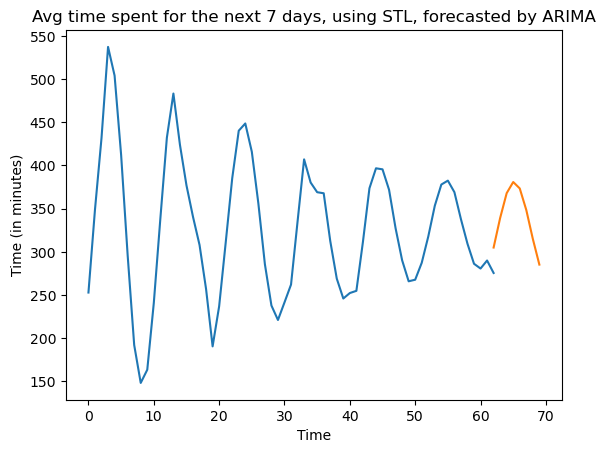

In [76]:
auto_model_avg = ARIMA(df_avg_stl_copy["count"].values[:-7], order=(2,0,3))  # (p, d, q)
model_fit = auto_model_avg.fit()


forecast_next_14_avg_time_spent = model_fit.forecast(steps=14)




mse = mean_squared_error(df_avg_stl_copy["count"].values[-7:], forecast_next_14_avg_time_spent[-14:-7])

print("--------- ARIMA Forecast on average time spent for next 7 days, using STL --------\n\n\n", forecast_next_14_avg_time_spent[-7:], sep = "")

mean_absolute_scaled_error = mase(df_avg_stl_copy["count"].values[-7:],forecast_next_14_avg_time_spent[-14:-7],df_avg_stl_copy["count"].values[:-7])
print("Mean absolute scaled error is: ",mean_absolute_scaled_error)

mean_abs_percentage_error = mean_absolute_percentage_error(df_avg_stl_copy["count"].values[-7:],forecast_next_14_avg_time_spent[-14:-7])*100
print("Mean absolute percentage error is: ",mean_abs_percentage_error)

plt.plot(df_avg_stl_copy["count"].values)

plt.title("Avg time spent for the next 7 days, using STL, forecasted by ARIMA")
plt.ylabel("Time (in minutes)")
plt.xlabel("Time")
indices = range(len(df_avg_stl_copy["count"])-1,len(df_avg_stl_copy["count"])+7)
plt.plot(indices,forecast_next_14_avg_time_spent[6:])

plt.show()

--------- ARIMA Forecast on average time spent for next 7 days, using Rolling --------


[359.57936859 391.65892915 400.22211461 382.29040632 344.48383346
 300.57791452 266.48473056]
Mean absolute scaled error is:  0.3826835463944197
Mean absolute percentage error is:  6.718926844373341


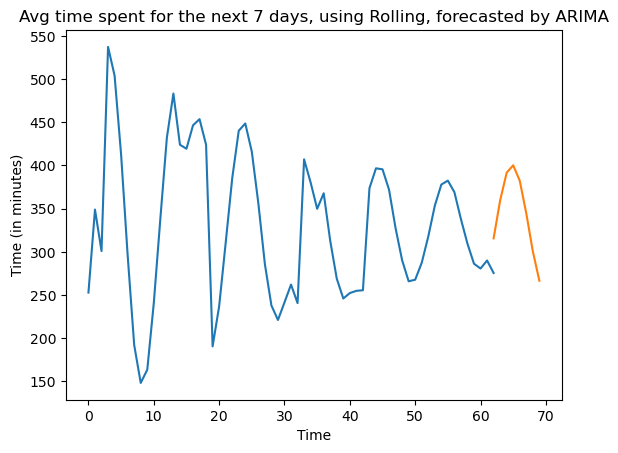

In [77]:
auto_model_avg = ARIMA(df_avg_rolling_copy["count"].values[:-7], order=(2,0,3))  # (p, d, q)
model_fit = auto_model_avg.fit()


forecast_next_14_avg_time_spent = model_fit.forecast(steps=14)



mse = mean_squared_error(df_avg_rolling_copy["count"].values[-7:], forecast_next_14_avg_time_spent[-14:-7])

print("--------- ARIMA Forecast on average time spent for next 7 days, using Rolling --------\n\n\n", forecast_next_14_avg_time_spent[-7:], sep = "")

mean_absolute_scaled_error = mase(df_avg_rolling_copy["count"].values[-7:],forecast_next_14_avg_time_spent[-14:-7],df_avg_rolling_copy["count"].values[:-7])
print("Mean absolute scaled error is: ",mean_absolute_scaled_error)

mean_abs_percentage_error = mean_absolute_percentage_error(df_avg_rolling_copy["count"].values[-7:],forecast_next_14_avg_time_spent[-14:-7])*100
print("Mean absolute percentage error is: ",mean_abs_percentage_error)

plt.plot(df_avg_rolling_copy["count"].values)
plt.title("Avg time spent for the next 7 days, using Rolling, forecasted by ARIMA")
plt.ylabel("Time (in minutes)")
plt.xlabel("Time")
indices = range(len(df_avg_rolling_copy["count"])-1,len(df_avg_rolling_copy["count"])+7)
plt.plot(indices,forecast_next_14_avg_time_spent[6:])


plt.show()